In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
with open('../benchmark/grammars/tiny_sql.lark', 'r') as f:
    grammar = f.read()

from genparse.util import lark_guide
guide = lark_guide(grammar)

In [5]:
from genparse.util import load_model_by_name
llm = load_model_by_name('mock-gpt2')

In [6]:
from genparse.batch_propose import CharacterProposalServer, BatchProposal, BatchProposalBaseline
from genparse.proposal import CharacterProposal

In [7]:
from genparse.batch_propose import Particle
from arsenal.timer import Benchmark

def make_particles(n_particles):
    return [Particle((), 0, (), 0, False) for _ in range(n_particles)]

In [8]:
max_tokens = 12
n_processes = 10
N = 10
T = Benchmark(f'Parallel vs Sequential {n_processes=}, {max_tokens=}')

for n_particles in [10, 20, 40, 80, 160, 320]:

    print(n_particles)

    guide1 = lark_guide(grammar)
    guide2 = lark_guide(grammar)

    char_server = CharacterProposalServer(llm, guide1, num_processes=n_processes, max_n_particles=350)
    batch_proposal = BatchProposal(char_server)
    sequential_proposal = BatchProposalBaseline(CharacterProposal(llm, guide2))

    char_server.start()

    for i in range(N):
        s_particles = make_particles(n_particles)
        with T['sequential'](i=i, n_particles=n_particles):
            while not all(p.done for p in s_particles):
                s_particles = sequential_proposal.batch_step(s_particles, max_tokens)

        p_particles = make_particles(n_particles)
        with T['parallel'](i=i, n_particles=n_particles):
            while not all(p.done for p in p_particles):
                p_particles = batch_proposal.batch_step(p_particles, max_tokens)

    char_server.cleanup()

10
20
40
80


In [10]:
i

7

In [8]:
T.compare()

parallel is 3.5786x faster than sequential (p=0.00000, median: sequential: 5.48956, parallel: 1.53398)


<Axes: title={'center': 'Parallel vs Sequential n_processes=10, max_tokens=12'}, xlabel='n_particles', ylabel='time (seconds)'>

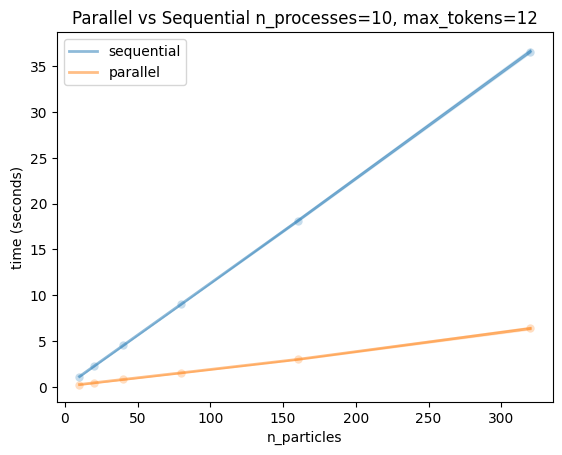

In [9]:
T.plot_feature('n_particles')